<a href="https://colab.research.google.com/github/ubermenchh/paper_implementations/blob/main/DeiT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Efficient Image Transformers (DeiT)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

import torchvision
import torchvision.models as models

import math

# DeiT Architecture

In [2]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size: int, num_heads: int, dropout: float = 0.2, batch_dim: int = 0):
        super(MultiHeadAttention, self).__init__()

        self.embed_size = embed_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.batch_dim = batch_dim

        self.dropout_layer = nn.Dropout(dropout)

        self.head_size = self.embed_size // self.num_heads

        assert self.head_size * self.num_heads == self.embed_size, "Heads cannot split Embedding size equally"

        self.Q = nn.Linear(self.embed_size, self.embed_size)
        self.K = nn.Linear(self.embed_size, self.embed_size)
        self.V = nn.Linear(self.embed_size, self.embed_size)

        self.linear = nn.Linear(self.embed_size, self.embed_size)

    def forward(self, q, k, v, mask=None):
        if self.batch_dim == 0:
            out = self.batch_0(q, k, v, mask)
        elif self.batch_dim == 1:
            out = self.batch_1(q, k, v, mask)

        return out

    def batch_0(self, q, k, v, mask=None):
        q_batch_size, q_seq_len, q_embed_size = q.size()
        k_batch_size, k_seq_len, k_embed_size = k.size()
        v_batch_size, v_seq_len, v_embed_size = v.size()

        q = self.Q(q).reshape(q_batch_size, q_seq_len, self.num_heads, self.head_size)
        k = self.K(k).reshape(k_batch_size, k_seq_len, self.num_heads, self.head_size)
        v = self.V(v).reshape(v_batch_size, v_seq_len, self.num_heads, self.head_size)

        attention = self.attention(q, k, v, mask=mask)
        concatenated = attention.reshape(v_batch_size, -1, self.embed_size)
        out = self.linear(concatenated)

        return out

    def batch_1(self, q, k, v, mask=None):
        q_seq_len, q_batch_size, q_embed_size = q.size()
        k_seq_len, k_batch_size, k_embed_size = k.size()
        v_seq_len, v_batch_size, v_embed_size = v.size()

        q = self.Q(q).reshape(q_seq_len, q_batch_size, self.num_heads, self.head_size).transpose(0, 1)
        k = self.K(k).reshape(k_seq_len, k_batch_size, self.num_heads, self.head_size).transpose(0, 1)
        v = self.V(v).reshape(v_seq_len, v_batch_size, self.num_heads, self.head_size).transpose(0, 1)

        attention = self.attention(q, k, v, mask=mask)
        concatenated = attention.reshape(-1, v_batch_size, self.embed_size)

        out = self.linear(concatenated)

        return out

    def attention(self, q, k, v, mask=None):
        scores = torch.einsum("bqhe,bkhe->bhqk", [q, k])

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        scores /= math.sqrt(self.embed_size)
        scores = F.softmax(scores, dim=-1)
        scores = self.dropout_layer(scores)
        attention = torch.einsum("bhql,blhd->bqhd", [scores, v])
        return attention


In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len: int = 5000, d_model: int = 300, dropout: float = 0.1, device="cpu"):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:x.size(0), :], requires_grad=False)
        return self.dropout(x)

In [5]:
class VisionEncoder(nn.Module):
    def __init__(self, embed_size, num_heads, hidden_size, dropout=0.1):
        super().__init__()

        self.embed_size = embed_size
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.dropout = dropout

        self.norm1 = nn.LayerNorm(self.embed_size)
        self.norm2 = nn.LayerNorm(self.embed_size)

        self.attention = MultiHeadAttention(self.embed_size, self.num_heads, dropout=dropout)

        self.mlp = nn.Sequential(
            nn.Linear(self.embed_size, 4*self.embed_size),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(4*self.embed_size, self.embed_size),
            nn.Dropout(self.dropout)
        )

    def forward(self, x):
        x = self.norm1(x)
        x = x + self.attention(x, x, x)
        x = x + self.mlp(self.norm2(x))
        return x

In [6]:
class VGG16_classifier(nn.Module):
    def __init__(self, classes, hidden_size, img_size_preprocess=224, preprocess_flag=False, dropout=0.1):
        super().__init__()

        self.classes = classes
        self.hidden_size = hidden_size
        self.img_size_preprocess = img_size_preprocess
        self.preprocess_flag = preprocess_flag
        self.dropout = dropout

        self.vgg16 = models.vgg16(pretrained=True)

        for parameter in self.vgg16.parameters():
            parameter.requires_grad = True

        self.preprocess = torchvision.transforms.Compose([
            torchvision.transforms.Resize(size=(self.img_size_preprocess, self.img_size_preprocess)),
            torchvision.transforms.ToTensor()
        ])

        self.vgg16.classifier = nn.Sequential(
            nn.Linear(25088, self.hidden_size*4),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_size*4, self.hidden_size*2),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_size*2, self.hidden_size),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_size, self.classes)
        )

    def forward(self, x):
        if self.preprocess_flag:
            x = self.preprocess(x)
        x = self.vgg16(x)
        return x

In [7]:
class DeiT(nn.Module):
    def __init__(self, image_size, channel_size, patch_size, embed_size, num_heads, classes, num_layers, hidden_size, teacher_model, dropout=0.1):
        super().__init__()

        self.image_size = image_size
        self.channel_size = channel_size
        self.p = patch_size
        self.num_patches = (image_size // patch_size)**2
        self.patch_size = channel_size * (patch_size**2)
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.classes = classes
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dropout = dropout

        self.dropout_layer = nn.Dropout(self.dropout)
        self.norm = nn.LayerNorm(self.embed_size)
        self.embeddings = nn.Linear(self.patch_size, self.embed_size)
        self.class_token = nn.Parameter(torch.randn(1, 1, self.embed_size))
        self.distillation_token = nn.Parameter(torch.randn(1, 1, self.embed_size))
        self.positional_encoding = nn.Parameter(torch.randn(1, self.num_patches + 2, self.embed_size))

        self.teacher_model = teacher_model
        for parameter in self.teacher_model.parameters():
            parameter.requires_grad = False
        self.teacher_model.eval()

        self.encoders = nn.ModuleList([])
        for layer in range(self.num_layers):
            self.encoders.append(VisionEncoder(self.embed_size, self.num_heads, self.hidden_size, self.dropout))

        self.classifier = nn.Sequential(
            nn.Linear(self.embed_size, self.classes)
        )

    def forward(self, x, mask=None):
        b, c, h, w = x.size()

        teacher_logits_vector = self.teacher_model(x)

        x = x.reshape(b, int((h / self.p) * (w / self.p)), c * self.p * self.p)
        x = self.embeddings(x)

        b, n, e = x.size()

        class_token = self.class_token.expand(b, 1, e)
        x = torch.cat((class_token, x), dim=1)

        distillation_token = self.class_token.expand(b, 1, e)
        x = torch.cat((x, distillation_token), dim=1)

        x = self.dropout_layer(x + self.positional_encoding)

        for encoder in self.encoders:
            x = encoder(x)

        x, distillation_token = x[:, 0, :], x[:, -1, :]

        x = self.classifier(self.norm(x))

        return x, teacher_logits_vector

# Data

In [8]:
from torchvision import transforms

train_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.RandomResizedCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(48),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
    ]
)

In [9]:
import torchvision

train_data = torchvision.datasets.CIFAR10(root='./data/train/', train=True, download=True, transform=train_transforms)
test_data = torchvision.datasets.CIFAR10(root='./data/test/', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:13<00:00, 12827547.07it/s]


Extracting ./data/train/cifar-10-python.tar.gz to ./data/train/


100%|██████████| 170498071/170498071 [00:13<00:00, 12835238.71it/s]


Extracting ./data/test/cifar-10-python.tar.gz to ./data/test/


In [10]:
import matplotlib.pyplot as plt
import numpy as np

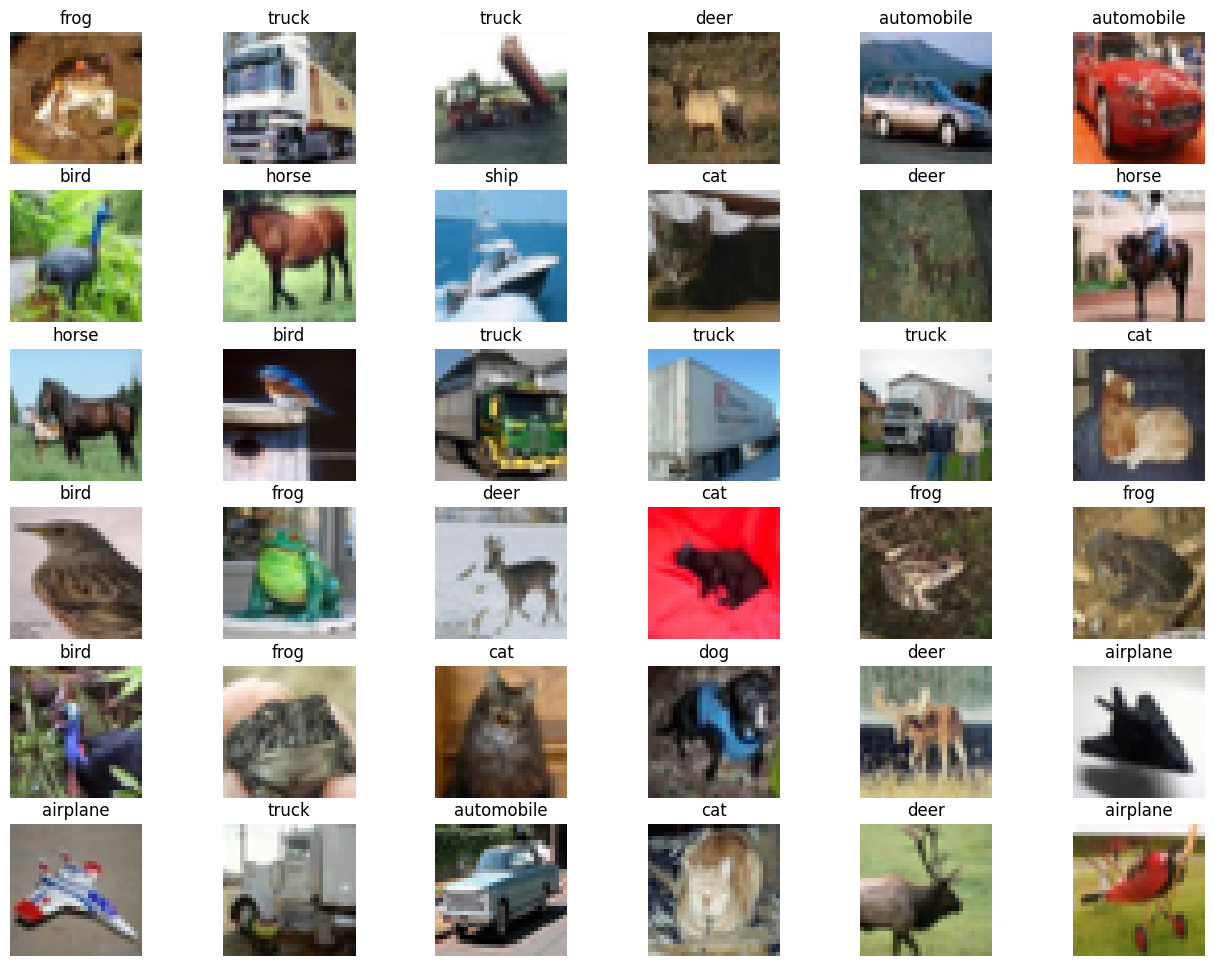

In [11]:
random_idx = np.random.randint(1, len(train_data), size=36)
fig, axes = plt.subplots(6, 6, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    ax.set_title(train_data.classes[train_data.targets[idx]])
    ax.imshow(train_data.data[idx])
    ax.axis('off')

In [12]:
batch_size = 32
epochs = 25
lr = 5e-5
gamma = 0.7

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
from torch.utils.data import Dataset, DataLoader

In [14]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [15]:
num_classes = len(train_data.classes)
num_classes

10

In [16]:
vgg = VGG16_classifier(num_classes, hidden_size=512, img_size_preprocess=32)
vgg

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 58.4MB/s]


VGG16_classifier(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
   

In [19]:
model = DeiT(
    image_size=32,
    channel_size=3,
    patch_size=4,
    embed_size=512,
    num_heads=8,
    classes=num_classes,
    num_layers=4,
    hidden_size=512,
    teacher_model=vgg,
    dropout=0.2
).to(device)

In [20]:
from torchsummary import summary

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [21]:
class HardDistillationLoss(nn.Module):
    def __init__(self):
        super().__init__()

        self.CE_teacher = nn.CrossEntropyLoss()
        self.CE_student = nn.CrossEntropyLoss()

    def forward(self, teacher_y, student_y, y):
        loss = (1/2) * (self.CE_student(student_y, y)) + (1/2) * (self.CE_teacher(teacher_y, y))
        return loss

# Training

In [22]:
criterion = HardDistillationLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

In [23]:
from tqdm import tqdm

In [24]:
loss_hist = {}
loss_hist["train accuracy"] = []
loss_hist["train loss"] = []

for epoch in range(1, epochs+1):
    model.train()

    epoch_train_loss = 0

    y_true_train = []
    y_pred_train = []

    for batch_idx, (img, labels) in enumerate(train_loader):
        img = img.to(device)
        labels = labels.to(device)

        preds, teacher_preds = model(img)

        loss = criterion(teacher_preds, preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_train.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_train.extend(labels.detach().tolist())

        epoch_train_loss += loss.item()

    loss_hist["train loss"].append(epoch_train_loss)

    total_correct = len([True for x, y in zip(y_pred_train, y_true_train) if x==y])
    total = len(y_pred_train)
    accuracy = total_correct * 100 / total

    loss_hist["train accuracy"].append(accuracy)

    print("-------------------------------------------------")
    print("Epoch: {} Train mean loss: {:.8f}".format(epoch, epoch_train_loss))
    print("       Train Accuracy%: ", accuracy, "==", total_correct, "/", total)
    print("-------------------------------------------------")

-------------------------------------------------
Epoch: 1 Train mean loss: 3454.96296000
       Train Accuracy%:  20.358 == 10179 / 50000
-------------------------------------------------
-------------------------------------------------
Epoch: 2 Train mean loss: 3319.36505461
       Train Accuracy%:  28.026 == 14013 / 50000
-------------------------------------------------
-------------------------------------------------
Epoch: 3 Train mean loss: 3265.62189245
       Train Accuracy%:  31.062 == 15531 / 50000
-------------------------------------------------
-------------------------------------------------
Epoch: 4 Train mean loss: 3228.36612070
       Train Accuracy%:  32.846 == 16423 / 50000
-------------------------------------------------
-------------------------------------------------
Epoch: 5 Train mean loss: 3198.01922750
       Train Accuracy%:  34.53 == 17265 / 50000
-------------------------------------------------
-------------------------------------------------
Epoch:

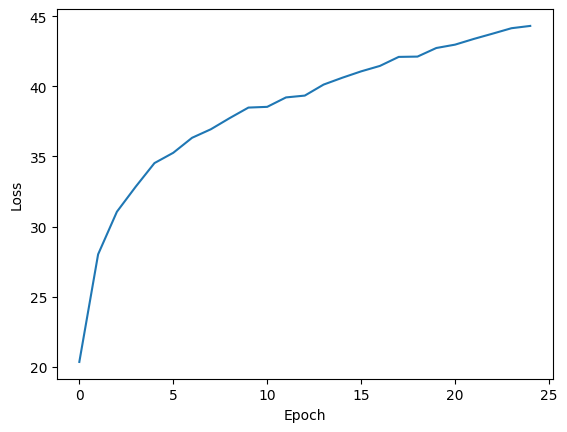

In [36]:
plt.plot(loss_hist["train accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

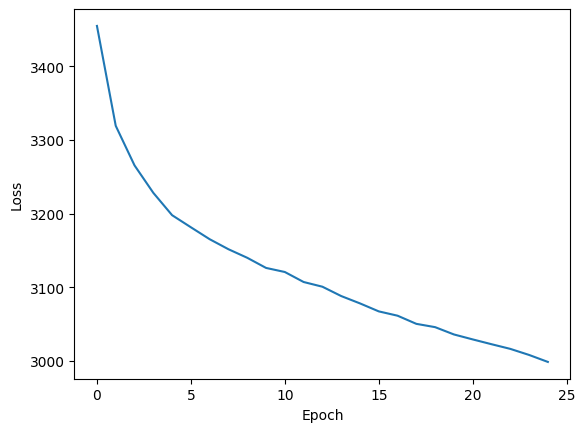

In [37]:
plt.plot(loss_hist["train loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Test

In [42]:
with torch.inference_mode():
    model.eval()

    y_true_test = []
    y_pred_test = []

    for batch_idx, (img, label) in enumerate(test_loader):
        img = img.to(device)
        label = label.to(device)

        preds, _ = model(img)

        y_pred_test.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_test.extend(label.detach().tolist())

    total_correct = len([True for x, y in zip(y_pred_test, y_true_test) if x==y])
    total = len(y_pred_test)
    accuracy = total_correct * 100 / total

    print("Test Accuracy%: ", accuracy, "==", total_correct, "/", total)

Test Accuracy%:  51.7 == 5170 / 10000


# Inference

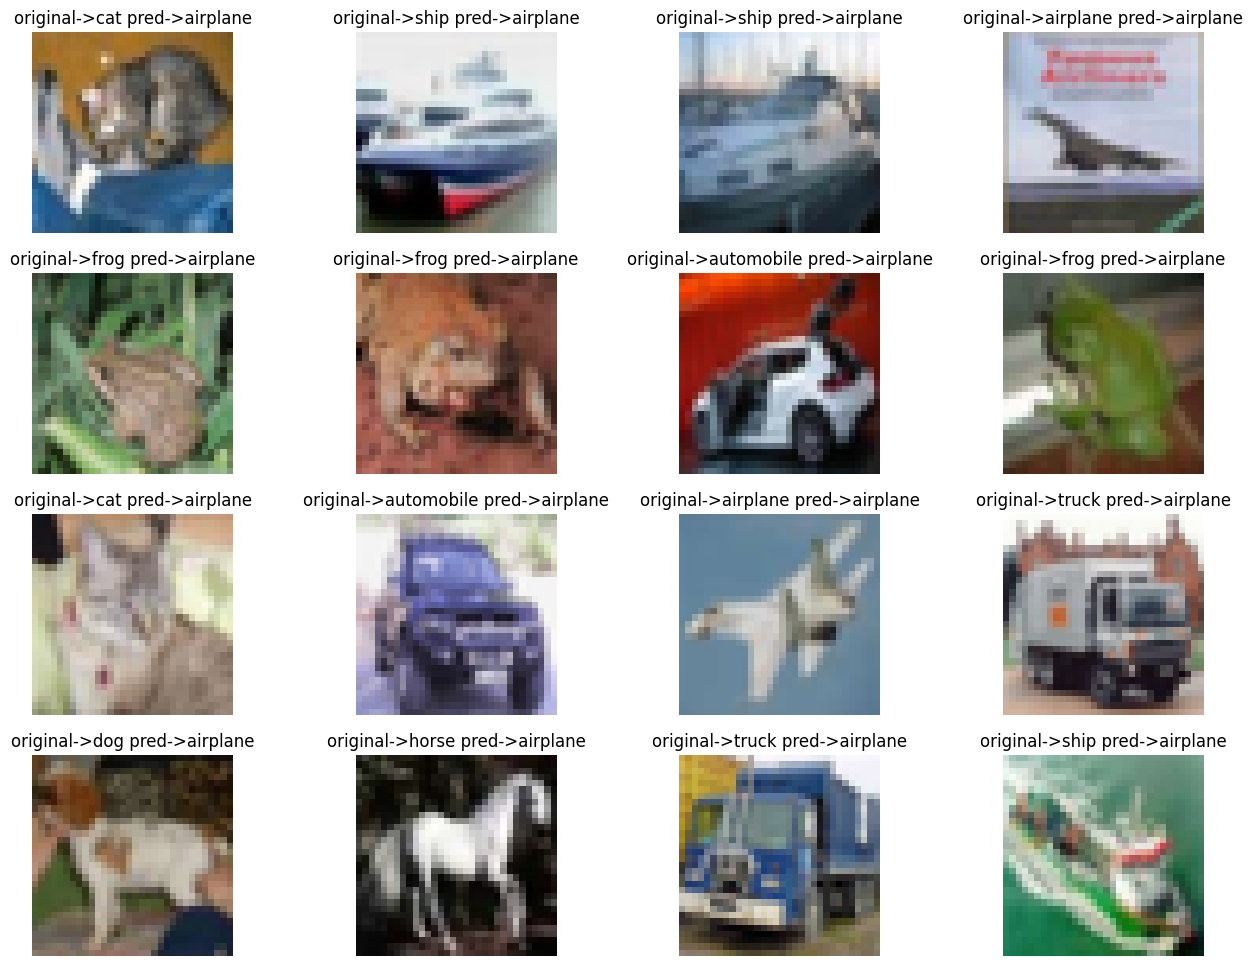

In [89]:
random_idx = np.random.randint(1, len(test_data), size=16)
fig, axes = plt.subplots(4, 4, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    pred, _ = model(torch.tensor(test_data.data[idx]).unsqueeze(0).permute(0, 3, 1, 2).float().to(device))
    pred_class = test_data.classes[int(pred.detach().argmax(dim=-1)[0])]

    ax.set_title(f"original->{test_data.classes[test_data.targets[idx]]} pred->{pred_class}")
    ax.imshow(test_data.data[idx])
    ax.axis('off')

# This model basically

<img src="https://i.imgflip.com/8afxtw.jpg" title="made at imgflip.com"/>